<a href="https://colab.research.google.com/github/chipsalliance/silicon-notebooks/blob/main/xls-adder-openlane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XLS adder with OpenLane

```
Copyright 2021 Google LLC.
SPDX-License-Identifier: Apache-2.0
```

Run a simple 1-bit adder design using the [XLS](https://google.github.io/xls/) high level synthesis toolkit thru the [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/) GDS to RTL flow targeting the open source [SKY130](https://github.com/google/skywater-pdk/) PDK.

## Install conda dependencies

In [2]:
import os
import pathlib
import sys

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
sys.path.append(str(site_package_path.resolve()))
CONDA_PREFIX = str(conda_prefix_path.resolve())
PATH = os.environ['PATH']
LD_LIBRARY_PATH = os.environ.get('LD_LIBRARY_PATH', '')
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}
%env LD_LIBRARY_PATH={CONDA_PREFIX}/lib:{LD_LIBRARY_PATH}
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --strict-channel-priority \
                        --channel litex-hub \
                        --channel main \
                        --channel conda-forge \
                        xls open_pdks.sky130a magic openroad netgen yosys \
                        click pyyaml tcllib gdstk

bin/micromamba
env: CONDA_PREFIX=/content/conda-env
env: PATH=/content/conda-env/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin
env: LD_LIBRARY_PATH=/content/conda-env/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64

                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

Empty environment created at prefix: /content/conda-env

                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

[+] 0.0s
[+] 0.1s
litex-hub/linux-64    ⣾  
litex-hub/noarch   

## Get OpenLane

In [8]:
!git clone --depth=1 https://github.com/The-OpenROAD-Project/OpenLane

fatal: destination path 'OpenLane' already exists and is not an empty directory.


## Write and test DSLX module


In [9]:
%%bash -c 'cat > adder.x; interpreter_main adder.x'

pub fn adder(in1: u1, in2: u1) -> u2 {
  let sum: u2 = in1 as u2 + in2 as u2;
  sum
}

#![test]
fn adder_test() {
  let _= assert_eq(adder(u1:0, u1:0), u2:0b00);
  let _= assert_eq(adder(u1:0, u1:1), u2:0b01);
  let _= assert_eq(adder(u1:1, u1:1), u2:0b10);
  _
}

[ RUN UNITTEST  ] adder_test
[            OK ]
[===============] 1 test(s) ran; 0 failed; 0 skipped.


## Generate IR and Verilog

In [10]:
design = 'adder'
!ir_converter_main --top={design} {design}.x > {design}.ir
!opt_main {design}.ir > {design}_opt.ir
!codegen_main --generator=combinational {design}_opt.ir > {design}.v
!cat {design}.v

module __adder__adder(
  input wire in1,
  input wire in2,
  output wire [1:0] out
);
  wire [1:0] sum;
  assign sum = {1'h0, in1} + {1'h0, in2};
  assign out = sum;
endmodule


## Run OpenLane Flow

In [20]:
%%writefile config.tcl
set ::env(DESIGN_NAME) __adder__adder

set ::env(VERILOG_FILES) "adder.v"

set ::env(CLOCK_TREE_SYNTH) 0
set ::env(CLOCK_PORT) ""

set ::env(FP_SIZING) absolute
set ::env(DIE_AREA) "0 0 50 50"
set ::env(PL_TARGET_DENSITY) 0.80
set ::env(PL_BASIC_PLACEMENT) 1

set ::env(RUN_LVS) 0
set ::env(RUN_CVC) 0
set ::env(RUN_KLAYOUT) 0

Overwriting config.tcl


In [12]:
%env PDK_ROOT={CONDA_PREFIX}/share/pdk
%env PDK=sky130A
%env STD_CELL_LIBRARY=sky130_fd_sc_hd
%env STD_CELL_LIBRARY_OPT=sky130_fd_sc_hd
%env TCLLIBPATH={CONDA_PREFIX}/share/tcltk/tcllib1.20
!OpenLane/flow.tcl -ignore_mismatches -overwrite \
                   -design . \
                   -to synthesis

env: PDK_ROOT=/content/conda-env/share/pdk
env: PDK=sky130A
env: TCLLIBPATH=/content/conda-env/share/tcltk/tcllib1.19
env: STD_CELL_LIBRARY=sky130_fd_sc_hd
env: STD_CELL_LIBRARY_OPT=sky130_fd_sc_hd
OpenLane 63b5966c2874da8bf01a831f0ee9dc68382a4958
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: Container manifest not found. What this likely means is that the container is severely out of date.
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: a1cf1b7c41dfccf1d38815278c543dd2f1e402dc, tested: fa87f8f4bbcc7255b6f0c0fb506960f531ae2392)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
The version of magic used in building the PDK does not match the version OpenLane was tested on (installed: 1178db42c64544e1cb6cb7374f24238e412bfc2

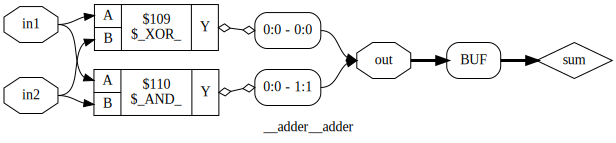

In [23]:
import graphviz
import pathlib

dot = sorted(pathlib.Path('runs').glob('*/tmp/synthesis/post_techmap.dot'))
graphviz.Source.from_file(dot[-1])

In [21]:
%env PDK_ROOT={CONDA_PREFIX}/share/pdk
%env PDK=sky130A
%env STD_CELL_LIBRARY=sky130_fd_sc_hd
%env STD_CELL_LIBRARY_OPT=sky130_fd_sc_hd
%env TCLLIBPATH={CONDA_PREFIX}/share/tcltk/tcllib1.20
!OpenLane/flow.tcl -ignore_mismatches \
                   -design .

env: PDK_ROOT=/content/conda-env/share/pdk
env: PDK=sky130A
env: STD_CELL_LIBRARY=sky130_fd_sc_hd
env: STD_CELL_LIBRARY_OPT=sky130_fd_sc_hd
env: TCLLIBPATH=/content/conda-env/share/tcltk/tcllib1.20
OpenLane 63b5966c2874da8bf01a831f0ee9dc68382a4958
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: Container manifest not found. What this likely means is that the container is severely out of date.
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: a1cf1b7c41dfccf1d38815278c543dd2f1e402dc, tested: fa87f8f4bbcc7255b6f0c0fb506960f531ae2392)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
The version of magic used in building the PDK does not match the version OpenLane was tested on (installed: 1178db42c64544e1cb6cb7374f24238e412bfc2

## Display layout

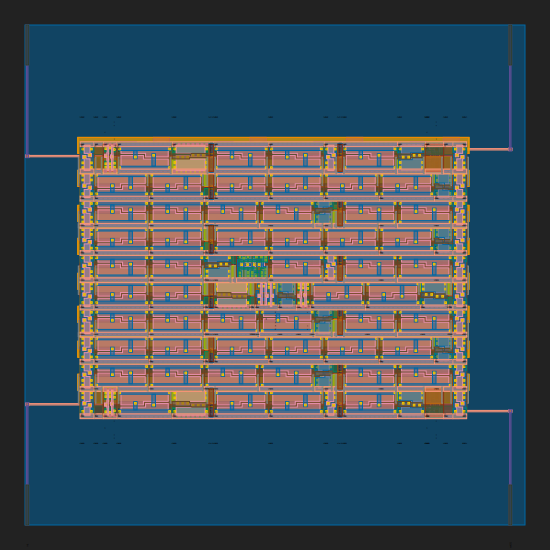

In [24]:
import gdstk
from IPython.display import SVG

gds = sorted(pathlib.Path('runs').glob('*/results/final/gds/*.gds'))
library = gdstk.read_gds(gds[-1])
top_cells = library.top_level()
top_cells[0].write_svg(f'{design}.svg')
SVG(f'{design}.svg')

# Dump flow report

In [25]:
import pandas as pd

pd.options.display.max_rows = None
csv = sorted(pathlib.Path('runs').glob('*/reports/metrics.csv'))
df = pd.read_csv(csv[-1])
df.transpose()

,0
design,/content
design_name,__adder__adder
config,adder
flow_status,flow failed
total_runtime,0h0m26s0ms
routed_runtime,-1
(Cell/mm^2)/Core_Util,-2.0
DIEAREA_mm^2,0.0025
CellPer_mm^2,-1
OpenDP_Util,2.86
